In [29]:
from pathlib import Path
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyfaidx import Fasta
from meth5 import MetH5File

from benchmark_pycometh.simulation.nanopolish_simulator import OmicsSimlaLoader
from nanoepitools.plotting.general_plotting import PlotArchiver, plot_2d_density
from benchmark_pycometh.config import module_config

In [3]:
omics_simla_base_dir = Path("/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/wgbs/")
omics_simla_profile_path = Path("/home/r933r/data/software/users/snajder/OmicsSIMLA_v0.6/profiles/methylation/WGBS/liver_profile.txt")
omics_simla_profile_map_path = Path("/home/r933r/data/software/users/snajder/OmicsSIMLA_v0.6/profiles/methylation/WGBS/map.txt")

rates = [0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60]
rates_str = [f"{r:.2f}" for r in rates]

In [32]:
loaders = {}
cpg_types = None
normal_source = None

for rate, rate_str in zip(rates, rates_str):
    print(rate, rate_str)
    omics_simla_dir = omics_simla_base_dir.joinpath(f"diffmet_{rate_str}")
    loader = OmicsSimlaLoader(omics_simla_dir, omics_simla_profile_path, omics_simla_profile_map_path)

    if cpg_types is None:
        cpg_types = pd.Series(data="normal", index=loader.summary.index)
        normal_source = pd.Series(data="none", index=loader.summary.index)

    idx_hypo = (loader.summary["Methylation_state"]=="Methylated") & (loader.summary["Theta"] < 0)
    idx_fuzzy = (loader.summary["Methylation_state"]=="Fuzzy") & (loader.summary["Theta"] != 0)
    idx_hyper = (loader.summary["Methylation_state"]=="Unmethylated") & (loader.summary["Theta"] > 0)
    relevant_cpgs = loader.summary.index[idx_hypo | idx_fuzzy | idx_hyper]
    cpg_types.loc[relevant_cpgs] = rate_str
    loaders[rate_str] = loader

    idx_normal = loader.summary["Theta"] == 0
    normal_source.loc[idx_normal] = rate_str

0.15 0.15
0.2 0.20
0.25 0.25
0.3 0.30
0.35 0.35
0.4 0.40
0.45 0.45
0.5 0.50
0.55 0.55
0.6 0.60


In [50]:
out_simla_merged_file = "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/wgbs/merged/sim1.methy"
cpg_types = list(cpg_types)


merged_summary = []


with open(out_simla_merged_file, "wt") as f, tqdm.tqdm(total=2*loader.summary.shape[0]) as pbar:
    for sample_i, sample in list(enumerate(loader.calls)):
        other_summaries = {r: loaders[r].summary.itertuples() for r in loaders}
        f.write(f"{sample} 1 {i}")

        cpg_types_i = 0
        while cpg_types_i < loader.summary.shape[0]:
            block_type = cpg_types[cpg_types_i]
            if block_type == "normal":
                source = normal_source[sample_i]
            else:
                source = block_type

            calls = loaders[source].calls[sample][cpg_types_i]
            f.write(f" {calls[0]},{calls[1]}")

            if sample_i == 0:
                for r in other_summaries:
                    row = next(other_summaries[r])
                    if r == source:
                        merged_summary.append(row)

            cpg_types_i+=1
            pbar.update(1)
        f.write("\n")
    print(cpg_types_i, loader.summary.shape)
    assert cpg_types_i == loader.summary.shape[0]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4565712/4565712 [00:55<00:00, 82549.52it/s]


2282856 (2282856, 5)


In [51]:
merged_summary = pd.DataFrame(merged_summary).set_index("Pos", drop=True).drop("Index", axis=1)

In [64]:
out_changepoints_file = "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/wgbs/merged/changepoints.txt"
last_type = None

merged_summary["segment"] = loader.segments
merged_summary["segment_type"] = loader.segment_types
summary_segments = merged_summary.groupby("segment")
with open(out_changepoints_file, "wt") as f:
    for segment in sorted(list(summary_segments.groups.keys())):
        segment_summary = summary_segments.get_group(segment)
        start = segment_summary.index[0].split(":")
        end = segment_summary.index[-1].split(":")
        chrom = start[0]
        start = start[1]
        end = end[1]
        assert all(segment_summary["Theta"].iloc[0] == t for t in segment_summary["Theta"])
        assert all(segment_summary["segment_type"].iloc[0] == t for t in segment_summary["segment_type"])
        f.write(f"{chrom}\t{start}\t{end}\t{segment_summary['segment_type'].iloc[0]}\t{segment_summary['Theta'].iloc[0]}\n")

AssertionError: 

In [55]:
out_summary_file = "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/wgbs/merged/Methylation_summary.txt"
merged_summary.to_csv(out_summary_file, sep=" ")

In [70]:
for loader in loaders.values():
    test = loader.summary.copy()#loader.segments
    test["segment"] = loader.segments

    test_segment = test.loc[test["segment"]==902]
    assert all(test_segment["Theta"].iloc[0] == t for t in test_segment["Theta"])

AssertionError: 

In [120]:
set(merged_summary.loc[merged_summary["Theta"] == -0.25]["segment"])

{171,
 337,
 587,
 1154,
 1276,
 1294,
 1473,
 1597,
 1898,
 2043,
 2190,
 2364,
 2381,
 2511,
 3291,
 3488,
 3652,
 3706,
 4266,
 4387,
 4480,
 4937,
 5502,
 5748,
 5808,
 5888,
 5982,
 6244,
 6308,
 6494,
 6771}

In [125]:
merged_summary.loc[merged_summary["segment"] == 1473]

,Methylation_rate,Methylation_state,Metylation_type,Theta,segment,segment_type
Pos,,,,,,
1:24152578,0.587428,Methylated,Normal,-0.25,1473,2
1:24152591,0.607197,Methylated,Normal,-0.25,1473,2
1:24152603,0.624442,Methylated,Normal,-0.25,1473,2
1:24152610,0.634059,Methylated,Normal,-0.25,1473,2
1:24152773,0.779498,Methylated,Normal,-0.25,1473,2
...,...,...,...,...,...,...
1:24163735,0.739755,Methylated,Normal,-0.25,1473,2
1:24164012,0.656421,Methylated,Normal,-0.25,1473,2
1:24164068,0.622444,Methylated,Normal,-0.25,1473,2


In [123]:
case = np.array(loaders["0.25"].calls["DCASES1"])[np.array(loaders["0.25"].segments) == 1473]
control = np.array(loaders["0.25"].calls["DCONTROLS1"])[np.array(loaders["0.25"].segments) == 1473]

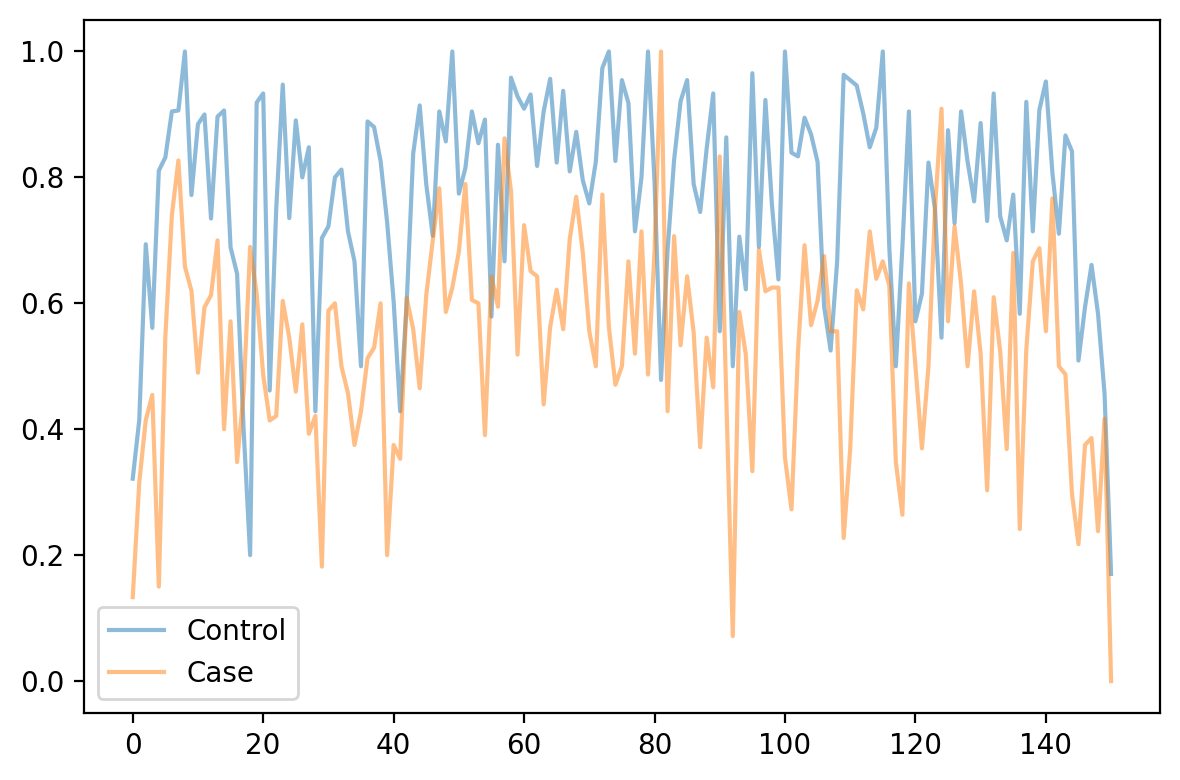

In [124]:
pa = PlotArchiver("simulation", headless=False, config={"plot_archive_dir": "/home/r933r/snajder/nanoepitools_plots/benchmark"})

pa.figure()
plt.plot([c[0]/c[1] for c in control], alpha=0.5, label="Control")
plt.plot([c[0]/c[1] for c in case], alpha=0.5, label="Case")
plt.legend()
plt.show()

In [119]:
merged_summary.loc[merged_summary["segment"] == 30]

,Methylation_rate,Methylation_state,Metylation_type,Theta,segment,segment_type
Pos,,,,,,
1:878986,0.607277,Methylated,Normal,-0.6,30,2
1:879044,0.654034,Methylated,Normal,-0.6,30,2
1:879097,0.693906,Methylated,Normal,-0.6,30,2
1:879100,0.696052,Methylated,Normal,-0.6,30,2
1:879123,0.712053,Methylated,Normal,-0.6,30,2
...,...,...,...,...,...,...
1:893700,0.597586,Methylated,Normal,-0.6,30,2
1:893717,0.571481,Methylated,Normal,-0.6,30,2
1:893734,0.542527,Methylated,Normal,-0.6,30,2
